# Exploratory Data Analysis (EDA)

In this notebook, I investigate the properties of the dataset to gain insights that might inform my modeling. I analyze:
- **Class distribution:** Verify the dataset balance and ensure no unexpected skew.
- **Text length distribution:** Check how article lengths differ among classes.
- **Readability and sentiment:** Compute additional metrics to see if humans and AI differ in writing style or tone.

Understanding these aspects helps validate my data and gives context to the modeling results. First, we load the processed dataset from the previous step.


In [1]:
# move up one level so that works
import os
os.chdir(os.path.abspath(os.path.join(os.getcwd(), "..")))
print("new cwd:", os.getcwd())


new cwd: c:\Testing\Final_Year_Project\AI-Text-Detection-Tool


In [2]:
import sys
!{sys.executable} -m pip install textstat vaderSentiment

In [3]:
import pandas as pd
from utils import features, viz
from utils.data_utils import config

# Load the full cleaned dataset for EDA
df = pd.read_parquet(config['paths']['cleaned_data'])
print(f"EDA dataset loaded: {df.shape[0]} samples, columns: {list(df.columns)}")
df.head(2)


EDA dataset loaded: 386901 samples, columns: ['text', 'label']


,text,label
0,london (reuters) - italy's 10-year government ...,human_written
1,the yankees vs tigers brawl was so crazy ... t...,human_written


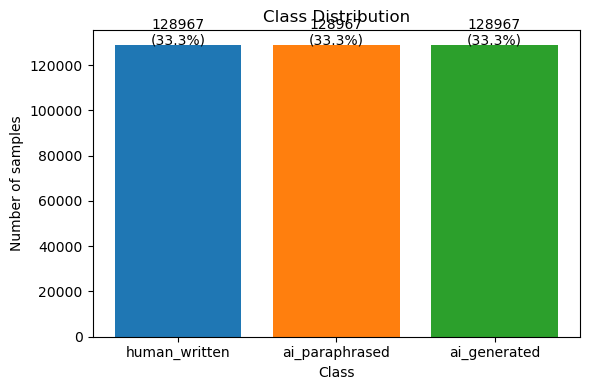

In [4]:
# Plot class distribution
fig = viz.plot_class_distribution(df, label_col='label', save_path="diagrams/class_distribution.png")


## Article Length Distribution

Do human-written texts tend to be longer or shorter than AI-generated ones? I examine the distribution of article lengths (in words) for each class:


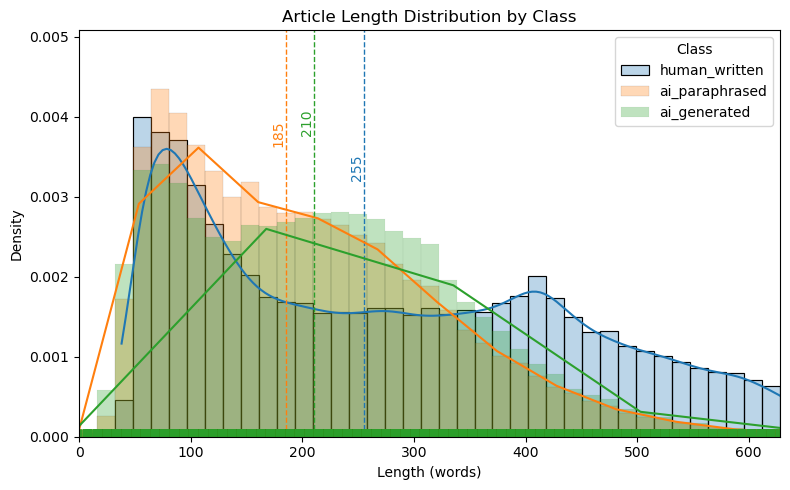

In [5]:
# Plot length distribution by class
fig_len = viz.plot_length_distribution(
    df,
    text_col='text',
    label_col='label',
    save_path="diagrams/length_distribution.png"
)


## Readability and Sentiment Analysis

I compute additional metrics for each class to see if there are stylistic differences:
- **Readability (Flesch Reading Ease):** Higher means easier reading.
- **Sentiment (VADER compound score):** Ranges from -1 (negative) to +1 (positive).

To keep things fast, I'll sample 5,000 texts per class, compute features, and compare class averages.


In [6]:
# Sample up to 5000 per class for speed
sample_df = pd.concat([
    df[df['label'] == 'human'].head(5000),
    df[df['label'] == 'ai_paraphrased'].head(5000),
    df[df['label'] == 'ai_generated'].head(5000)
], ignore_index=True)

# Compute readability, sentiment, and lexical diversity
sample_df = features.compute_all_features(sample_df)

# Print average values by class
print("Average Readability (higher = easier) by class:")
print(sample_df.groupby('label')['readability'].mean().to_dict())
print("\nAverage Sentiment (compound) by class:")
print(sample_df.groupby('label')['sentiment'].mean().to_dict())

Average Readability (higher = easier) by class:
{'ai_generated': 37.798382000000004, 'ai_paraphrased': 43.779804}

Average Sentiment (compound) by class:
{'ai_generated': 0.40368234000000003, 'ai_paraphrased': 0.30720416}


In [ ]:
# --- Visualize average readability and sentiment by class ---
import matplotlib.pyplot as plt
import seaborn as sns

# Compute per‐class averages
avg_df = sample_df.groupby('label')[['readability','sentiment']].mean().reset_index()

# 1) Bar plot of average readability
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.barplot(data=avg_df, x='label', y='readability', ax=ax[0])
ax[0].set_title("Avg. Readability by Class")
ax[0].set_xlabel("")
ax[0].set_ylabel("Flesch Reading Ease")

# 2) Bar plot of average sentiment
sns.barplot(data=avg_df, x='label', y='sentiment', ax=ax[1])
ax[1].set_title("Avg. Sentiment by Class")
ax[1].set_xlabel("")
ax[1].set_ylabel("VADER Compound Score")

fig.tight_layout()
plt.savefig("diagrams/readability_sentiment_bar.png", dpi=150)
plt.show()


# --- (Optional) Distributions via boxplots ---
fig2, ax2 = plt.subplots(1,2, figsize=(12,4))
sns.boxplot(data=sample_df, x='label', y='readability', ax=ax2[0])
ax2[0].set_title("Readability Distribution by Class")
ax2[0].set_xlabel("")
ax2[0].set_ylabel("Flesch Reading Ease")

sns.boxplot(data=sample_df, x='label', y='sentiment', ax=ax2[1])
ax2[1].set_title("Sentiment Distribution by Class")
ax2[1].set_xlabel("")
ax2[1].set_ylabel("VADER Compound Score")

fig2.tight_layout()
plt.savefig("diagrams/readability_sentiment_box.png", dpi=150)
plt.show()
